In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import os
import shutil
import json
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
train_dataset = image_dataset_from_directory('/content/drive/MyDrive/newDataset/training',
                                             shuffle=True,
                                             batch_size= 25,
                                             image_size= (224,224),
                                             seed=42)


Found 12596 files belonging to 100 classes.


In [ ]:
class_labelss = train_dataset.class_names

In [ ]:
validation_dataset = image_dataset_from_directory('/content/drive/MyDrive/newDataset/validation',
                                             shuffle=True,
                                             batch_size= 25,
                                             image_size= (224,224),
                                             seed=42)

Found 500 files belonging to 100 classes.


In [ ]:
Autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=Autotune)


In [ ]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

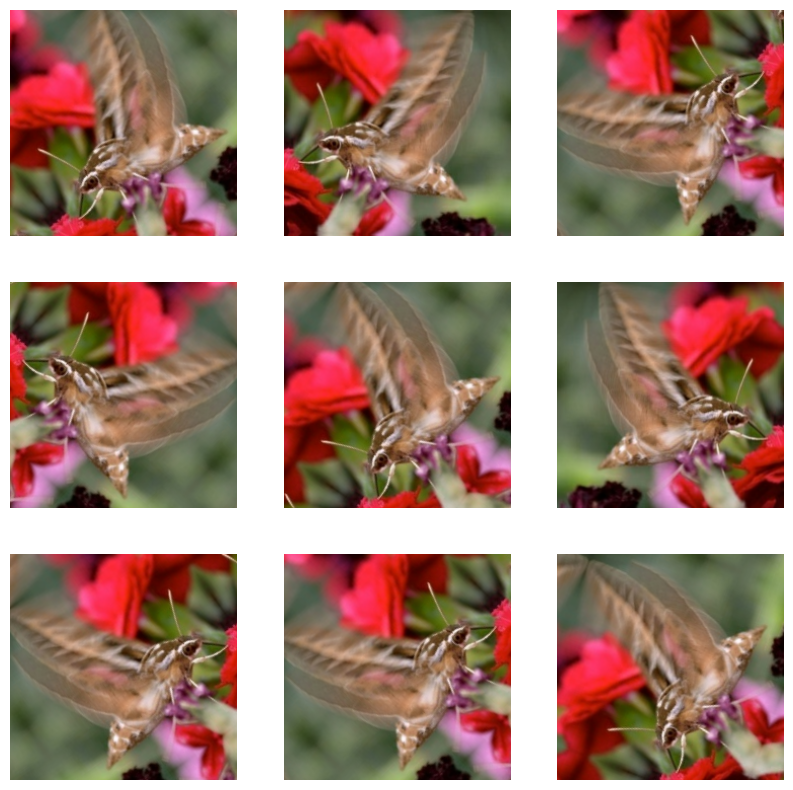

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input_mobileNet = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3),
                                                   include_top = False,
                                                   weights= 'imagenet')

In [ ]:
inputs = tf.keras.Input(shape = (224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input_mobileNet(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(rate = 0.2)(x)

outputs = layers.Dense(units = 100, activation = 'linear')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

In [ ]:
mobileNet_tune = model.layers[4]
mobileNet_tune.trainable = True

In [ ]:
for layer in mobileNet_tune.layers[:100]:
    layer.trainable = False

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(loss = loss_function,
              optimizer = optimizer,
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs = 16, validation_data = validation_dataset)

Epoch 1/16
504/504 [==============================] - 998s 2s/step - loss: 1.6422 - accuracy: 0.6470 - val_loss: 0.8298 - val_accuracy: 0.7780
Epoch 2/16
504/504 [==============================] - 963s 2s/step - loss: 0.4380 - accuracy: 0.8873 - val_loss: 0.3209 - val_accuracy: 0.9200
Epoch 3/16
504/504 [==============================] - 951s 2s/step - loss: 0.2821 - accuracy: 0.9248 - val_loss: 0.2033 - val_accuracy: 0.9580
Epoch 4/16
504/504 [==============================] - 959s 2s/step - loss: 0.2151 - accuracy: 0.9420 - val_loss: 0.2062 - val_accuracy: 0.9460
Epoch 5/16
504/504 [==============================] - 930s 2s/step - loss: 0.1727 - accuracy: 0.9529 - val_loss: 0.2039 - val_accuracy: 0.9480
Epoch 6/16
504/504 [==============================] - 925s 2s/step - loss: 0.1363 - accuracy: 0.9626 - val_loss: 0.1899 - val_accuracy: 0.9460
Epoch 7/16
504/504 [==============================] - 925s 2s/step - loss: 0.1220 - accuracy: 0.9657 - val_loss: 0.1676 - val_accuracy: 0.9580

In [ ]:
# plot
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

#Loss - Accuracy graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='train loss')
plt.plot(epochs, val_loss, 'b', label='val loss')
plt.title('Train and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='val accuracy')
plt.title('Train and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()